# Introduction to Prophet

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

<a id='load-datasets'></a>
## Load Datasets

This data was downloaded from the Hass Avocado Board website in May of 2018.

The data represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.

In [2]:
avocado = pd.read_csv('data/avocado_sales.csv')

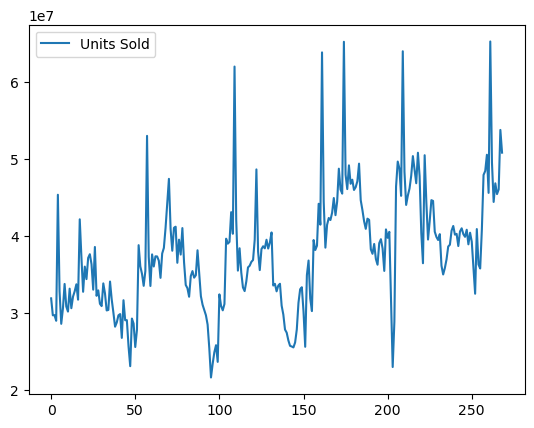

In [3]:
avocado.plot()
plt.show()

## Seasonality, Holiday Spikes

### Prophet Basics

Prophet is open source library for time series forecasting developed by Facebook. Prophet builds a model composed of a trend seasonality, and holiday components by fitting a curve through the time series data points.

Unique features include:
- Adding holiday effects (Superbowl, Christmas, New Years, 4th of July)
- Specify points where the trend change
- Adjust seasonality smoothness

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well." - https://github.com/facebook/prophet

In [4]:
from prophet import Prophet

# Prophet requires the time series to be a 2 column pd.dataframe with the Date as 'ds' and the values as 'y'.
avocado_prophet = avocado.reset_index().rename(columns = {'Date':'ds', 'Units Sold':'y'})
avocado_prophet.head()

,index,ds,y
0,0,1/4/2015,31937187.88
1,1,1/11/2015,29733071.63
2,2,1/18/2015,29756578.85
3,3,1/25/2015,29026679.70
4,4,2/1/2015,45396358.48


In [5]:
# Initialize the Prophet model instance.
m = Prophet(weekly_seasonality=False, daily_seasonality=False)

# Fit the model on the time series.
m.fit(avocado_prophet)

Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well.

In [6]:
# Create a DataFrame of future dates to create forecasts for. 
future = m.make_future_dataframe(periods=52, freq = 'W-Sun')
future.tail()

,ds
316,2021-02-21
317,2021-02-28
318,2021-03-07
319,2021-03-14
320,2021-03-21


In [7]:
# Use the model to create forecasts.
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
311,2021-01-17,5.132482e+07,4.565392e+07,5.675856e+07
312,2021-01-24,5.466498e+07,4.899891e+07,5.982909e+07
313,2021-01-31,5.715882e+07,5.150374e+07,6.263663e+07
314,2021-02-07,5.690437e+07,5.143675e+07,6.240023e+07
315,2021-02-14,5.373890e+07,4.798306e+07,5.905438e+07
316,2021-02-21,4.980421e+07,4.394249e+07,5.531709e+07
317,2021-02-28,4.785865e+07,4.246175e+07,5.318930e+07
318,2021-03-07,4.883878e+07,4.350654e+07,5.491302e+07
319,2021-03-14,5.111026e+07,4.581085e+07,5.664049e+07
320,2021-03-21,5.220037e+07,4.694188e+07,5.799932e+07


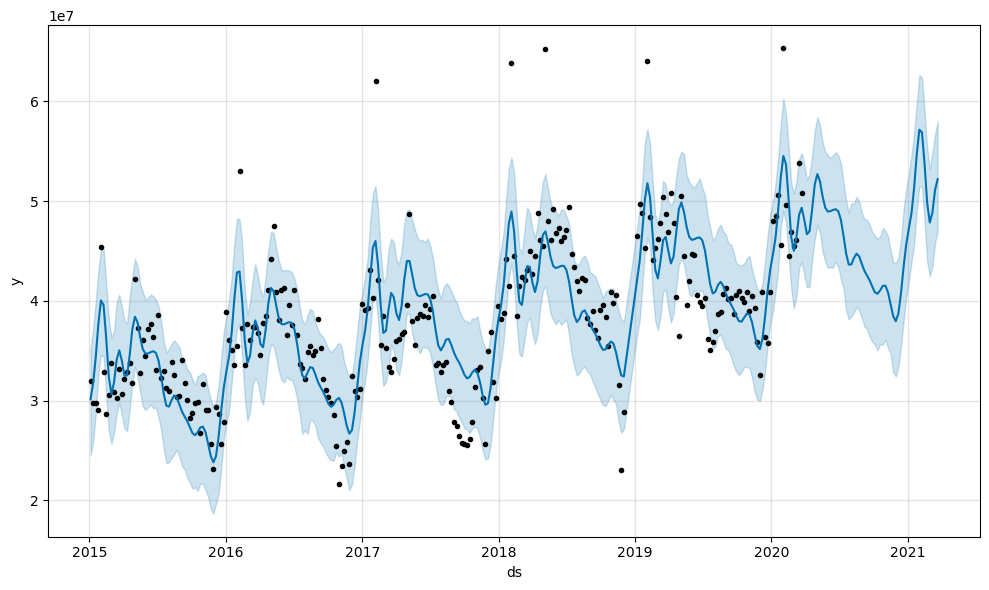

In [8]:
# Plot the forecasts. Uncertainity intervals of width 80% are show by default as the shaded blue region.
fig1 = m.plot(forecast)

You might notice from the graphs above that Prophet automatically accounts for outliers. 

**Actually, the model is missing the holiday spikes in avocado sales around the Superbowl and the 4th of July.**

### Adding Holiday Effects
The Prophet API provides a convenient method to add holiday effects or other floating days that might explain sudden changes in the time series. Let's add features to the model to account for these "holiday" effects of the Superbowl and the 4th of July.

In [9]:
# lower_window = -1 specifies that we should expect the week before the holiday to experience an increase in sales.
# if lower_window = 0, then we would expect a spike in only the week that contains the holiday.

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2015-02-01', '2016-02-07', '2017-02-05','2018-02-04', '2019-02-03', '2020-02-02','2021-02-07']),
  'lower_window': -1,
  'upper_window': 0,
})

independence_day = pd.DataFrame({
  'holiday': 'independence_day',
  'ds': pd.to_datetime(['2015-07-04', '2016-07-04', '2017-07-04','2018-07-04', '2019-07-04', '2020-07-04','2021-07-04']),
  'lower_window': -1,
  'upper_window': 0,
})

holidays = pd.concat((superbowls, independence_day))
holidays


,holiday,ds,lower_window,upper_window
0,superbowl,2015-02-01,-1,0
1,superbowl,2016-02-07,-1,0
2,superbowl,2017-02-05,-1,0
3,superbowl,2018-02-04,-1,0
4,superbowl,2019-02-03,-1,0
5,superbowl,2020-02-02,-1,0
6,superbowl,2021-02-07,-1,0
0,independence_day,2015-07-04,-1,0
1,independence_day,2016-07-04,-1,0
2,independence_day,2017-07-04,-1,0


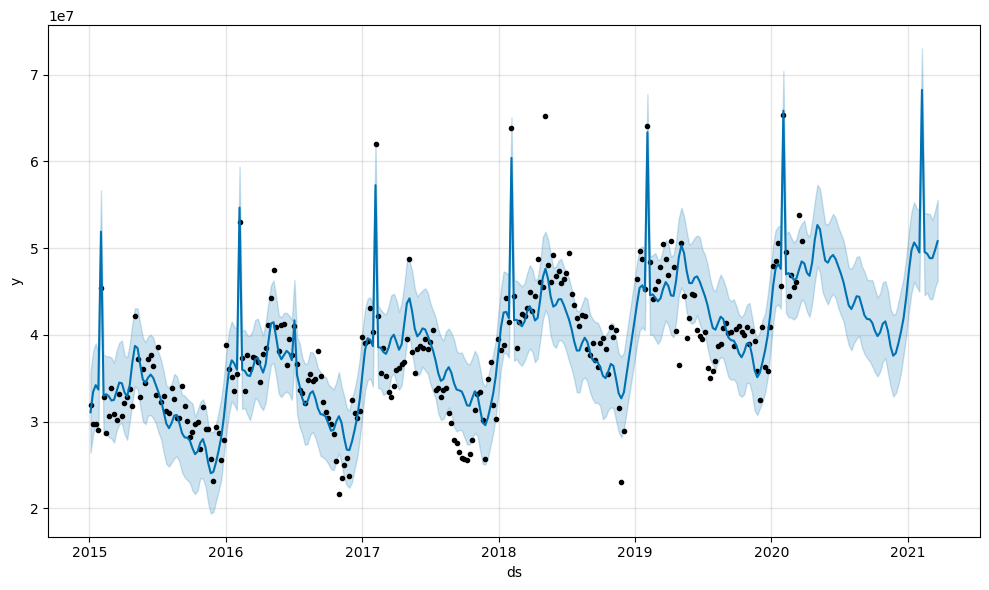

In [10]:
m = Prophet(holidays=holidays, weekly_seasonality=False,  daily_seasonality=False)
m.fit(avocado_prophet);
future = m.make_future_dataframe(periods=52, freq = 'W-Sun')
forecast = m.predict(future)
fig1 = m.plot(forecast)

We can also access to the components found by the Prophet model by calling the `plot_components`function.

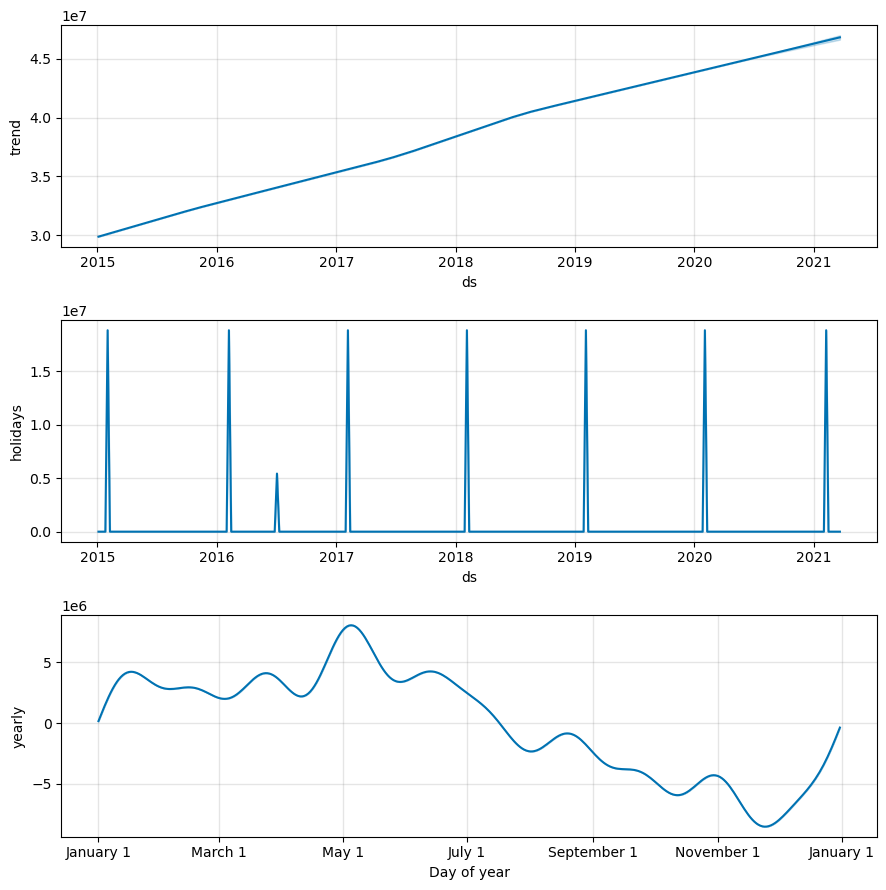

In [11]:
fig2 = m.plot_components(forecast)

Note how the spikes near the Superbowl are now clearly captured by the model. Also the 4th July of 2016 have a significant impact.

**References/Additional Reading:**
- Detailed Overview: https://www.youtube.com/watch?v=kKg2OUVxbSA
- Github Source Code: https://github.com/facebook/prophet